# Imports

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")


# Read Data

In [2]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat
# 10 hours of non zeroes 
def adherence_check1(df):
  df1 = df.copy()
  df1['Not Zero'] = df1['Steps'] > 0
  df1 = df1.groupby('Date').sum()
  df1 = df1['Not Zero'] > 10 
  return df1

#Greater than 500 steps
def adherence_check2(df,min):
  df1 = df.copy()
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps']> min
  return df1 

#Active in 3 time blocks 
def adherence_check3(df):
  df1 = df.copy()
  bins = [-1,2,10,14,25,np.inf]
  names = ['3','1','2', '3', '3']
  df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names, ordered=False)
  df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
  df1['Steps within timeblock'] = df1['Steps']> 0 
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps within timeblock'] ==3 
  return df1

#Combining it all into 1 dataframe
def three_method_table(x):
  valid_1= adherence_check1(x)
  valid_2= adherence_check2(x,500)
  #valid_3= adherence_check3(x)
  #result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
  result = pd.concat([valid_1,valid_2], axis=1, join='inner')
  result.reset_index(level=0, inplace=True)
  #result.columns = ["Date", "10 Hours Non Zero","Steps > 500","3 Timeblock"]
  result.columns = ["Date", "10 Hours Non Zero","Steps > 500"]
  #result['All 3 True'] = result["3 Timeblock"]*result["10 Hours Non Zero"]*result["Steps > 500"]
  result['All 3 True'] = result["10 Hours Non Zero"]*result["Steps > 500"]
  result_sum = result.sum()
  return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['10 Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > 500'] == True)
    elif(measure == 3):
        mask = (df3['All 3 True'] == True)
    filtered_df = df3.loc[mask].drop(['10 Hours Non Zero', 'Steps > 500', 'All 3 True'], axis=1)
    #filtered_df = filtered_df.drop('index', axis=1)
    return filtered_df

# Method 1 calculates daily steps based on all the step acitivity that is available during the day
def run_method_1(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def run_method_2(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def run_method_3(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, filter_measure, start_time, end_time):
    
    df = read_CLEAN_data(filename)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = run_method_2(filtered_df)
    dailysteps_method1 = run_method_1(filtered_df)
    dailysteps_method3 = run_method_3(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3
   
    

In [3]:
filename = "../../../data/cleaned/User1.csv"

filter_measure = 2
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, filter_measure, start_time, end_time)


In [4]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(1533, 1)

# Method 1

# Steps to take to implement (S)ARIMA

1) Check for Seasonality <br />
2) Check for Stationarity <br />
3) If not Stationary perform Rolling/ Smoothing/ Shifting/ Differentiation <br />
4) Obtain SARIMA Parameters <br />
5) Data Splitting and Model evaluation by plots <br />
6) Data Forecasting


### 1) Check For Seasonality

##### Simple Plot

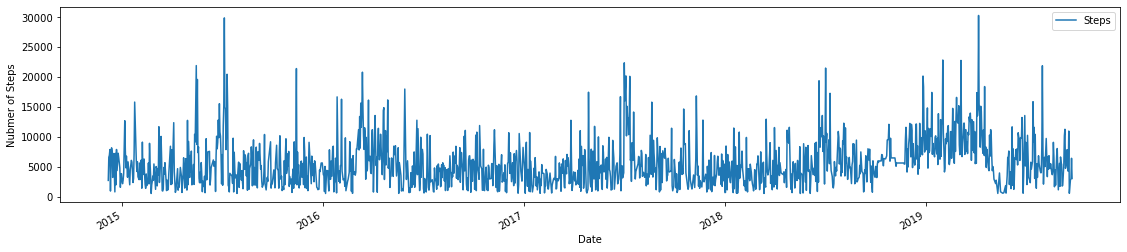

In [6]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

#### Seasonal Decompose Plot

Using the command, we can decompose the time series into three distinct components: Trend, Seasonality and noise

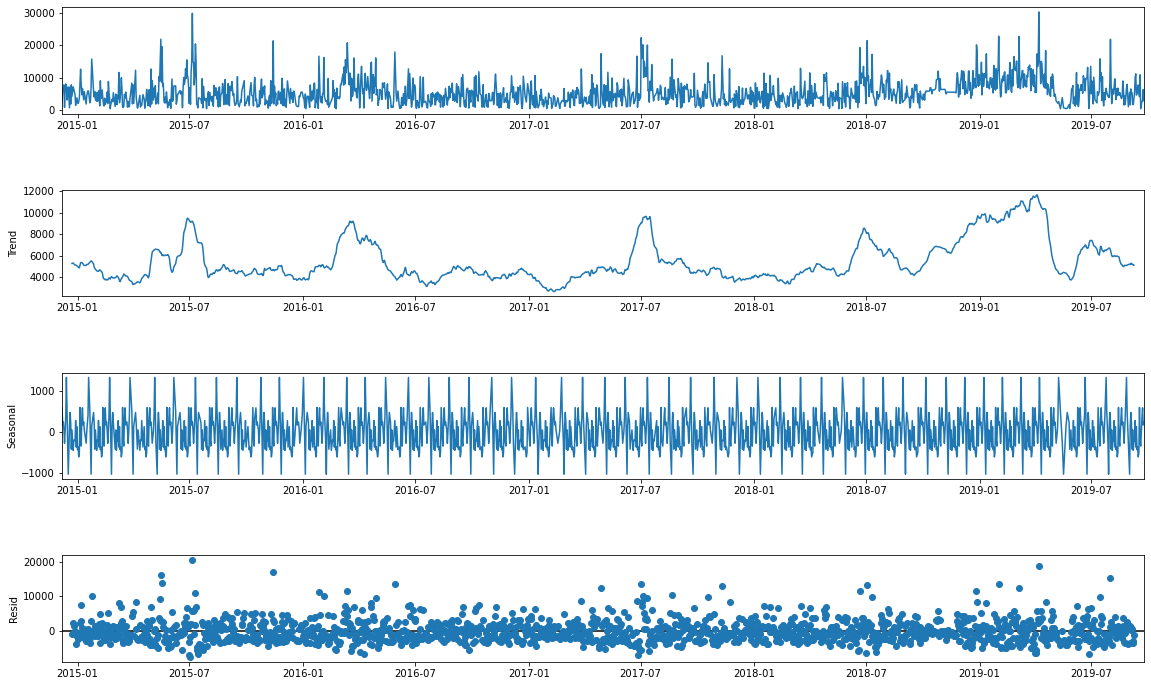

In [7]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

After adherence, it appears that the data does not have much seasonality anymore. We can observe however, that there is a slight trend every 3 years that the user walks more during that year

# Check for data Stationarity

Will use this function to test for stationarity by using the **Augmented Dickey-Fuller test**

where <br />
$H_0$: If failed to be rejected, time series data is not stationary <br />
$H_1$: If $H_0$ is rejected, it means the time series data is stationary

In [8]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

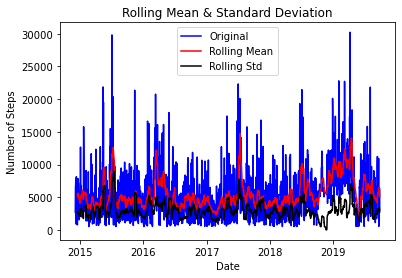

Results of Dickey Fuller Test:
ADF Test Statistic               -5.594462
p-value                           0.000001
#Lags Used                       13.000000
Number of Observations Used    1519.000000
Critical Value (1%)              -3.434662
Critical Value (5%)              -2.863445
Critical Value (10%)             -2.567784
dtype: float64


In [9]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 0.000001 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

## Making Data Stationary

As the data is stationary, we do not need to perform any transformation of the data to achieve stationarity.

### Data Transformation to acheive Normality

#### Log Transformation

In [10]:
#Estimating trend
#ds_method1 = np.log(ds_method1)
#plt.plot(ds_method1)

# (S)ARIMA Parameters

#### ACF and PACF plots

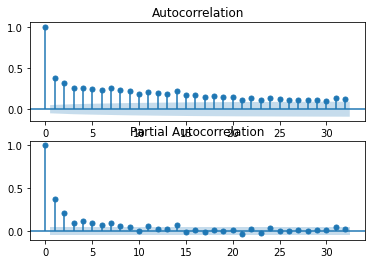

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1])
plt.show()

In [12]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=1, start_q=1,
                           max_p=9, max_q=9, m=12,
                            seasonal=False,
                           d=0 , trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29352.347, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31401.321, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29864.704, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=30793.344, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29333.325, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29608.800, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=29331.550, Time=0.56 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=29536.138, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=29336.454, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=29331.877, Time=0.56 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=29329.639, Time=0.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=29340.633, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=29329.171, Time=0.35 sec
 ARIMA(0,0,3)(0,0,0)[0]  

So, the best set of paramters to select is  **ARIMA(1,0,3)(0,0,0)[0]** I selected m = 12 to represent the yearly number of months each 'season' runs for 

Optimization terminated successfully.
         Current function value: 9.562368
         Iterations: 2
         Function evaluations: 127


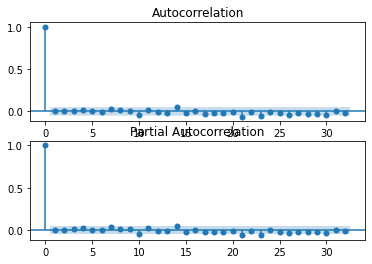

In [13]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(1,0,3), seasonal_order = (0,0,0,0)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [14]:
train = ds_method1.loc['2014-12-07':'2018-10-26']
test = ds_method1.loc['2018-10-28':]
stepwise_model.fit(train)

ARIMA(order=(1, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(1, 0, 3),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1533
Model:               SARIMAX(1, 0, 3)   Log Likelihood              -14621.070
Date:                Sun, 15 Nov 2020   AIC                          29252.141
Time:                        01:08:00   BIC                          29278.803
Sample:                             0   HQIC                         29262.064
                               - 1533                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9982      0.002    596.396      0.000       0.995       1.001
ma.L1         -0.7612      0.024    -31.426      0.000      -0.809      -0.714
ma.L2         -0.0481      0.031     -1.541      0.1

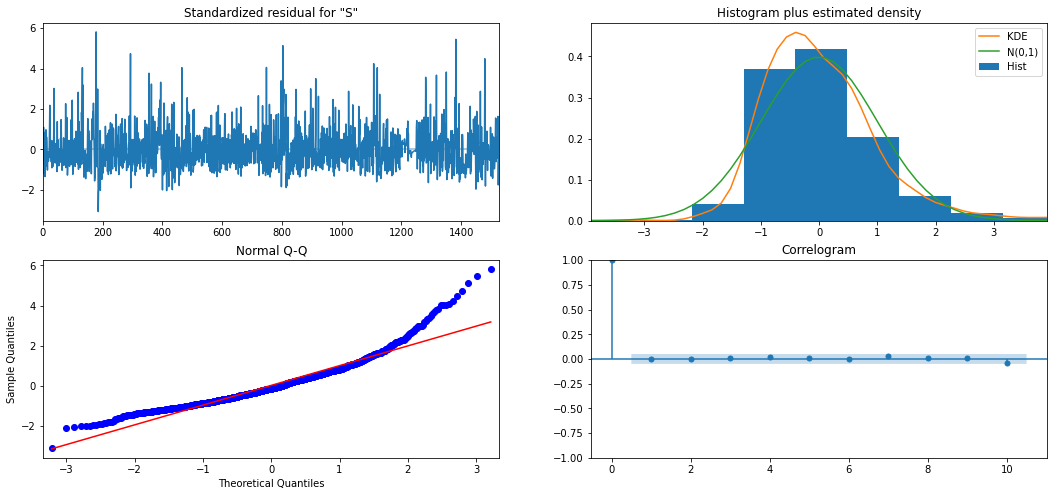

In [16]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

### (S)ARIMA Model Validation

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

Train Set 80%, Validation 20%

In [18]:
# the 20% point test data is on the specified date below
split_date = '2018-10-26'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 3),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [19]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 21448749.2027
Root Mean Squared Error: 4631.2794
Mean Absolute Error: 3292.7184


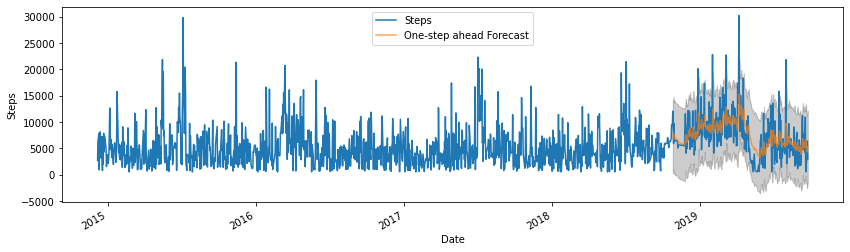

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-26'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

# Method 2

In [21]:
#method_1.set_index('Date',inplace=True)
ds_method2.set_index('Date',inplace=True)
ds_method2.head()

,Steps
Date,
2014-12-07,2693.0
2014-12-08,6550.0
2014-12-09,6879.0
2014-12-10,7845.0
2014-12-11,916.0


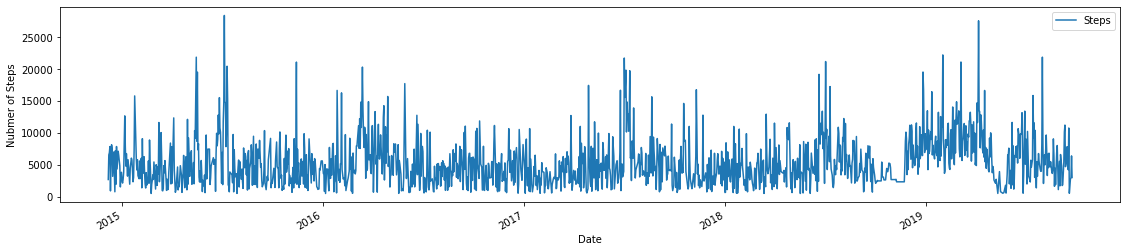

In [22]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

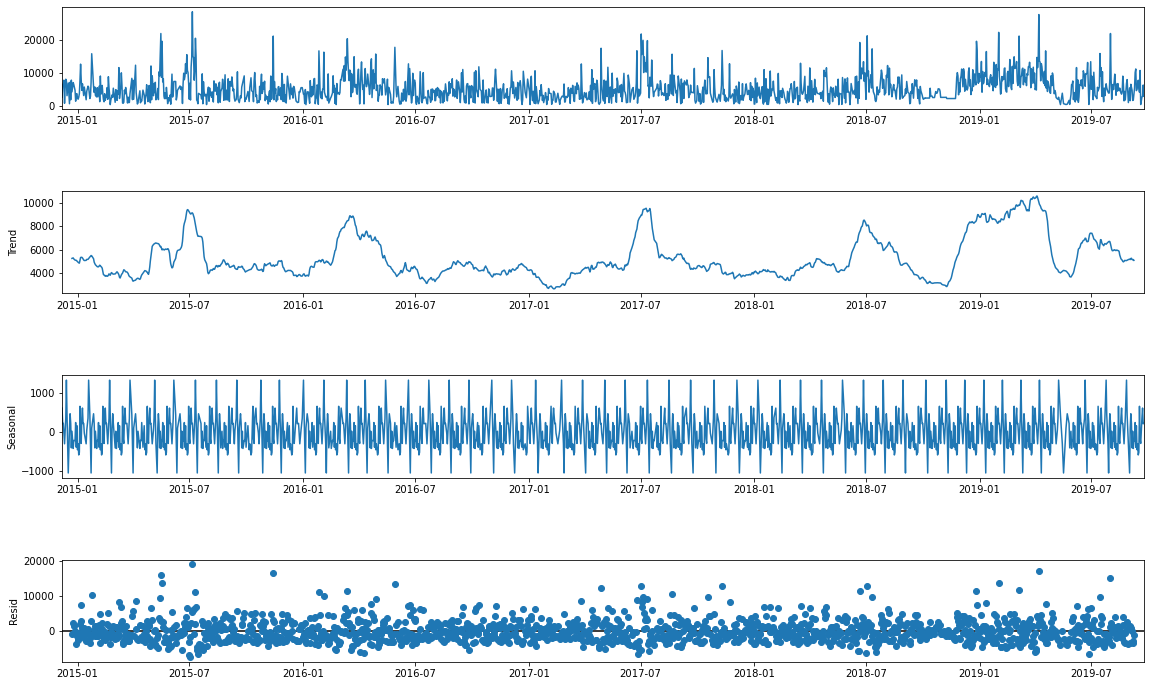

In [23]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

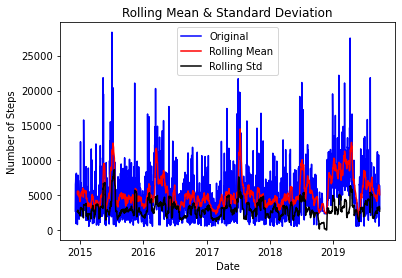

Results of Dickey Fuller Test:
ADF Test Statistic            -5.875398e+00
p-value                        3.168285e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.519000e+03
Critical Value (1%)           -3.434662e+00
Critical Value (5%)           -2.863445e+00
Critical Value (10%)          -2.567784e+00
dtype: float64


In [24]:
test_stationarity(ds_method2)

Again, data appears to be stationary so no transformation of the data was required.

In [25]:
#Estimating trend
#ds_method2 = np.log(ds_method2)
#plt.plot(ds_method2)

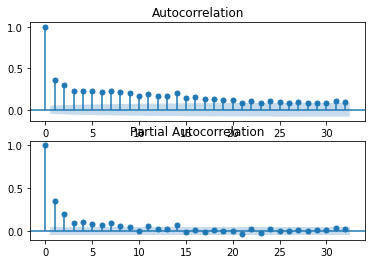

In [26]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

In [30]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=9, max_q=10, m=0,
                            seasonal=False,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31281.651, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29803.615, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=30688.053, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29548.879, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=29478.359, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=29419.712, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=29383.736, Time=0.14 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=29360.452, Time=0.10 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=29333.331, Time=0.12 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=29322.023, Time=0.17 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=29315.152, Time=0.18 sec
 ARIMA(9,0,1)(0,0,0)[0]             : AIC=29274.648, Time=1.50 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=29274.445, Time=0.96 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=29277.569, Time=0.76 sec
 ARIMA(8,0,2)(0,0,0

Optimization terminated successfully.
         Current function value: 9.554844
         Iterations: 1
         Function evaluations: 120


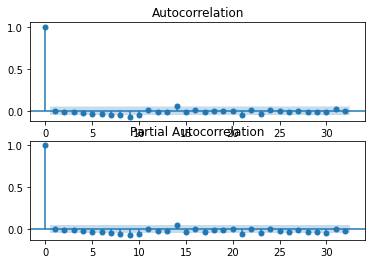

In [37]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(9,0,0), seasonal_order = (0,0,0,0)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [38]:
train = ds_method2.loc['2014-12-07':'2018-10-26']
test = ds_method2.loc['2018-10-28':]
stepwise_model.fit(train)

ARIMA(order=(9, 0, 0), scoring_args={}, suppress_warnings=True)

In [39]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(9,0,0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1533
Model:               SARIMAX(9, 0, 0)   Log Likelihood              -14561.717
Date:                Sun, 15 Nov 2020   AIC                          29143.434
Time:                        01:09:48   BIC                          29196.725
Sample:                             0   HQIC                         29163.271
                               - 1533                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2621      0.023     11.534      0.000       0.218       0.307
ar.L2          0.1621      0.024      6.710      0.000       0.115       0.209
ar.L3          0.0592      0.025      2.413      0.0

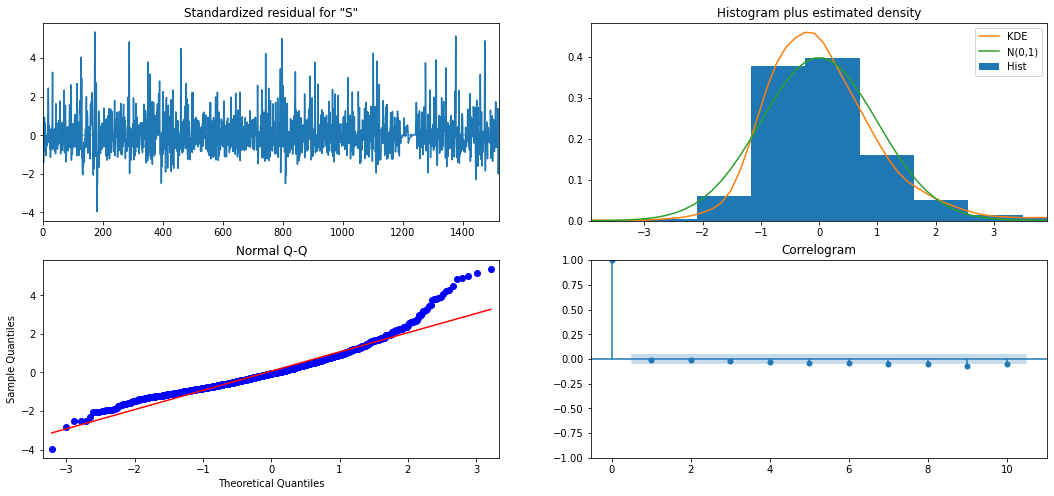

In [40]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [42]:
# the 20% point test data is on the specified date below
split_date = '2018-10-26'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(9,0, 0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [43]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 54313503.3588
Root Mean Squared Error: 7369.7696
Mean Absolute Error: 6153.0112


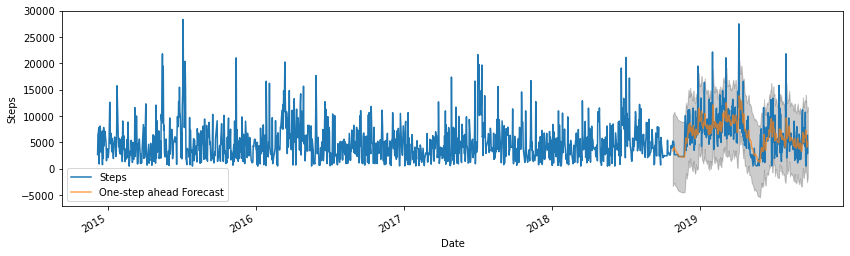

In [44]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-26'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

# Method 3

In [45]:
#method_1.set_index('Date',inplace=True)
ds_method3.set_index('Date',inplace=True)

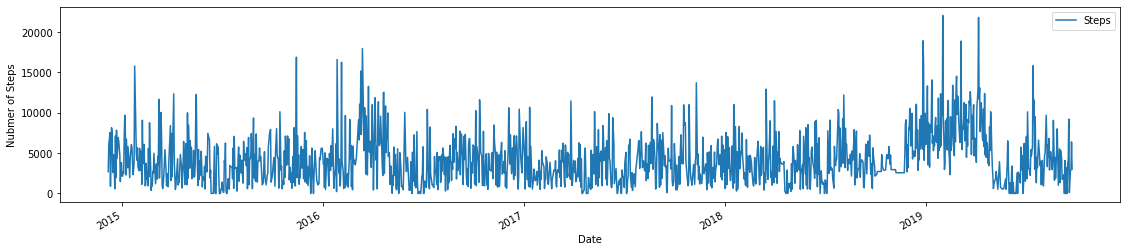

In [46]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

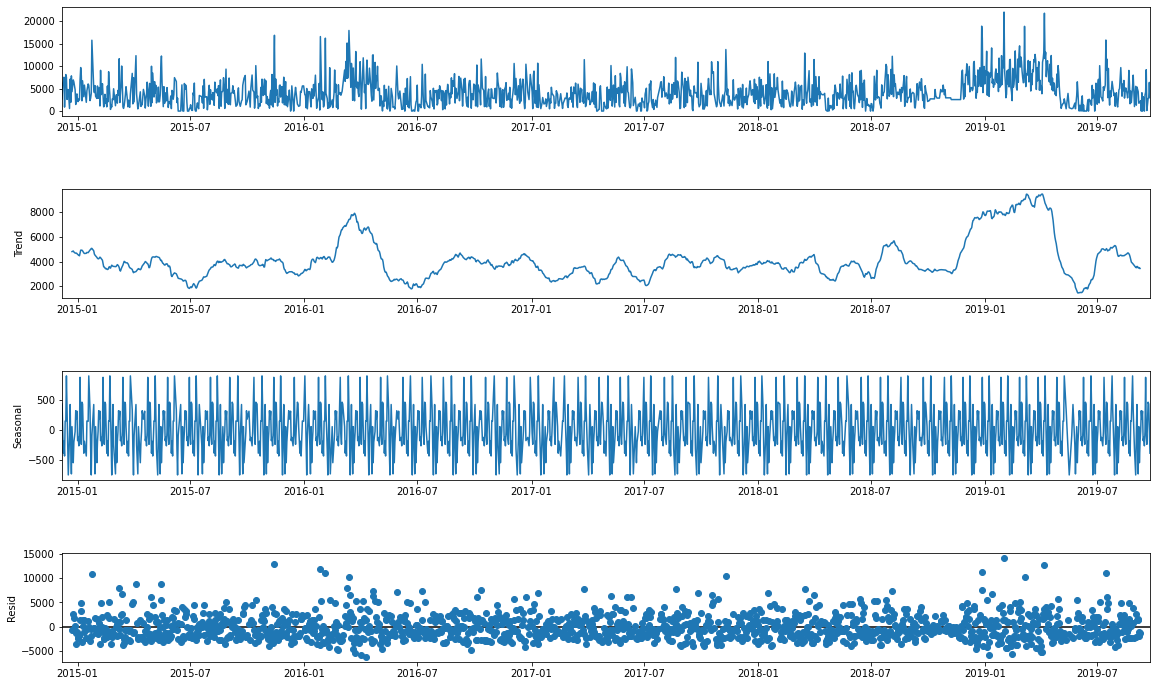

In [47]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

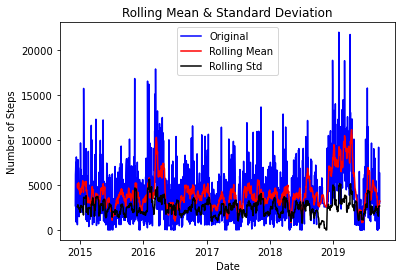

Results of Dickey Fuller Test:
ADF Test Statistic               -5.041767
p-value                           0.000018
#Lags Used                       13.000000
Number of Observations Used    1519.000000
Critical Value (1%)              -3.434662
Critical Value (5%)              -2.863445
Critical Value (10%)             -2.567784
dtype: float64


In [48]:
test_stationarity(ds_method3)

In [49]:
#Estimating trend
#ds_method3 = np.log(ds_method3)
#plt.plot(ds_method3)

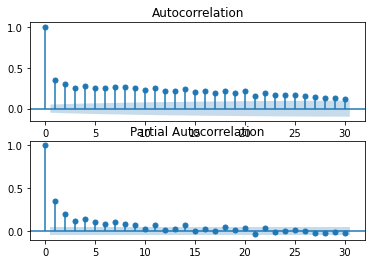

In [50]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3, lags=30, ax=ax[1])
plt.show()

In [56]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=0,
                            seasonal=False,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30578.319, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29223.250, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=30014.970, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=28969.897, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=28880.918, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=28808.463, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=28770.195, Time=0.08 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=28651.388, Time=0.46 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=28653.063, Time=0.36 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=28651.483, Time=0.40 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=28650.093, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=28647.699, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=28647.175, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=28643.064, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0

Optimization terminated successfully.
         Current function value: 9.339335
         Iterations: 4
         Function evaluations: 190


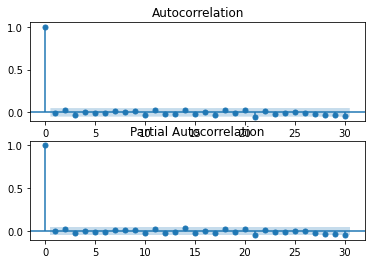

In [57]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(2,0,1), seasonal_order = (0,0,0,0)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [58]:
train = ds_method3.loc['2014-12-07':'2018-10-26']
test = ds_method3.loc['2018-10-28':]
stepwise_model.fit(train)

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [59]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(2,0,1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1533
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -14306.647
Date:                Sun, 15 Nov 2020   AIC                          28621.293
Time:                        01:11:38   BIC                          28642.628
Sample:                             0   HQIC                         28629.233
                               - 1533                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0914      0.032     33.707      0.000       1.028       1.155
ar.L2         -0.0937      0.032     -2.914      0.004      -0.157      -0.031
ma.L1         -0.8988      0.015    -58.392      0.0

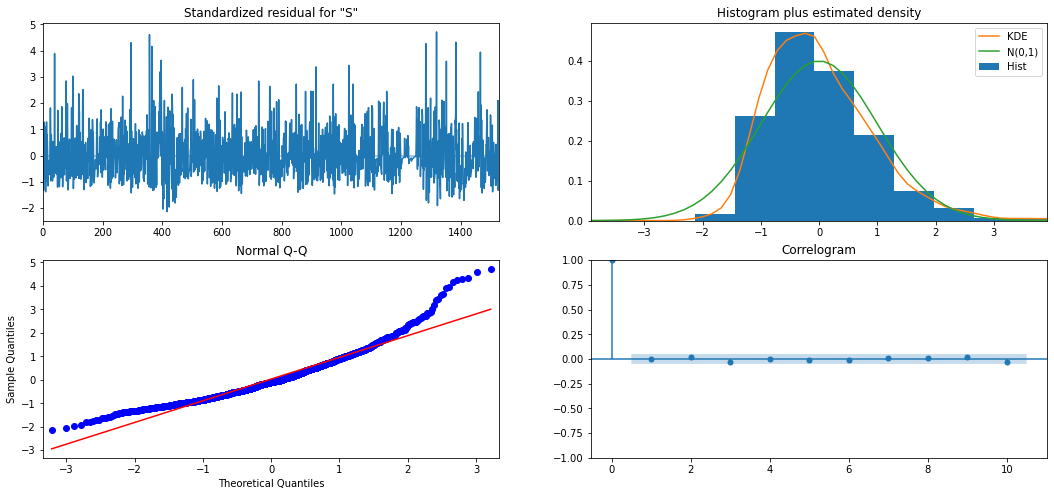

In [60]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [62]:
# the 20% point test data is on the specified date below
split_date = '2018-10-26'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2,0,1),
                                seasonal_order=(0,0,0,0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [63]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 23115005.3058
Root Mean Squared Error: 4807.8067
Mean Absolute Error: 3552.3833


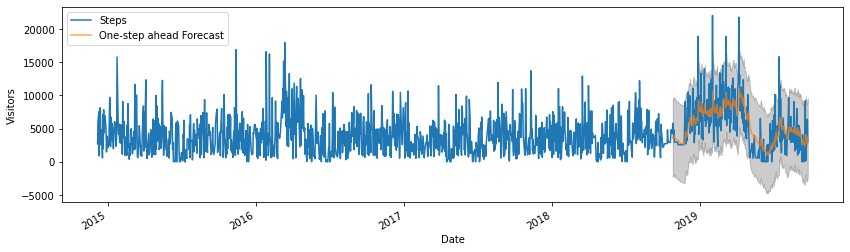

In [64]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-26'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

In [65]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,2.144875e+07,4631.2794,3292.7184
1,Method 2,5.431350e+07,7369.7696,6153.0112
2,Method 3,2.311501e+07,4807.8067,3552.3833


Based on the above predictions, we can observe that **Model 2** appears to perform the best prediction while **Model 1** has the worst prediction. However, the **RMSE** value of **Model 3** is lowest. But i would say that **Model 2** performed the best here